# 5-1 GAN による画像生成のメカニズムと DCGAN の実装

## フォルダの準備
これまで通り，make_folders_and_data_downloads.ipynb を実行してフォルダの準備をしておく．
また，この章では scikit-learn を使うためインストールしておく．

## Generator のメカニズム
この章では手書き数字の7と8の生成を目指す．
教師データとして MNIST の画像データを使用する．  
ここで GAN の G (Generator) の役割について整理する．
生成する画像は 64×64 の4,096ピクセルを持ち，白黒の1チャネルで0から255の256段階の値を持つ．
よって，画像パターンは $256^{4096}\approx10^{3277}$ のパターンがある．
この内，人が見て数字に見えるパターンが何通りあるかわからないが，このようなパターンを生成するのが G の役割である．  
ただし，G が毎回同じ画像を生成したり，教師データと全く同じ画像を生成したりするだけでは意味がない．
ネットワークには様々なパターンの生成につながる乱数を入力する．  
G は一切の教師データなしには手書き文字の生成はできないので，教師データとして人の書いた数字の画像を与え，これらとは異なるが手書き数字に見える画像を生成するように学習する．

このような G は次のように実装される．
入力された乱数から画像が生成するため，データの次元が拡大し，各次元の要素数も増加していく必要がある．
これを実現するのが nn.ConvTranspose2d() ユニットである．
transpose convolution または deconvolution は日本語では転置畳み込みと呼ぶ．
下の図にた畳み込みと転置畳み込みの操作を示す．

<img src="../image/p245.png">

通常の畳み込みは隣接ピクセルをカーネルでまとめて計算し，物体の小さなズレなど吸収した局所特徴量を求めることができ，計算結果は元のサイズより小さくなる．
転置畳み込みでは，カーネルを入力データの1ピクセルごとにカーネルを掛け算して，全部のセルの掛け算結果を最後に足す．  
上の図からも転置畳み込みによって画像サイズが大きくなることがわかる．
よって，転置畳み込みを繰り返すことで特徴量マップの要素数が多くなり，所望のピクセルサイズの画像を得られる．
ここで，転置畳み込みのカーネルをうまく学習させることができれば，人が見て手書き数字に見える画像が生成できる．  
ちなみに，これまで使ってきたアップサンプリングでは，上記のようなカーネルの概念はなく，単純に画像を引き伸ばしピクセル間を何らかの方法で補間しているだけなので，転置畳み込みのような複雑な拡大処理は実現できない．

## Generator の実装
ここでは DCGAN (Deep Convolutional Generative Adversarial Network) を実装する．
Generator は ConvTranspose2d とバッチノーマライゼーション，ReLU を1セットにしたlayer を4回繰り返し，特徴量サイズを徐々に大きくする．
各 layer において最初の layer ほどチャネル数を多くした転置畳み込みにして徐々にチャネル数を減らす．
4つの layer を通ったあと，最後に ConvTranspose2d の出力のチャネル数を1にして，活性化関数を ReLU ではなく Tanh にして-1から1の出力になるよ
うな出力レイヤーを作成する．
実装において変数 z は入力の乱数を示す．
なお入力する乱数の次元を z_dim = 20 としているが，20にとくに意味はなく，生成画像が所望の多様性をもつ次元数が確保されれば良い．
今回は適当に20にしている．

In [1]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, z_dim=20, image_size=64):
        super(Generator, self).__init__()
        
        self.layer1 = nn.Sequential(nn.ConvTranspose2d(z_dim, image_size * 8, kernel_size=4, stride=1), 
                                    nn.BatchNorm2d(image_size * 8), 
                                    nn.ReLU(inplace=True))
        self.layer2 = nn.Sequential(nn.ConvTranspose2d(image_size * 8, image_size * 4, kernel_size=4, stride=2, padding=1), 
                                    nn.BatchNorm2d(image_size * 4), 
                                    nn.ReLU(inplace=True))
        self.layer3 = nn.Sequential(nn.ConvTranspose2d(image_size * 4, image_size * 2, kernel_size=4, stride=2, padding=1), 
                                    nn.BatchNorm2d(image_size * 2), 
                                    nn.ReLU(inplace=True))
        self.layer4 = nn.Sequential(nn.ConvTranspose2d(image_size * 2, image_size, kernel_size=4, stride=2, padding=1), 
                                    nn.BatchNorm2d(image_size), 
                                    nn.ReLU(inplace=True))
        self.last = nn.Sequential(nn.ConvTranspose2d(image_size, 1, kernel_size=4, stride=2, padding=1), 
                                  nn.Tanh())
        
    
    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)
        
        return out

動作確認を兼ねて上で実装した Generator で画像を生成してみる．

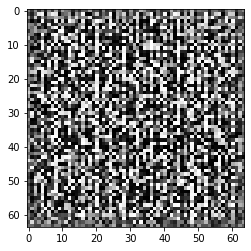

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

G = Generator()

# 入力の乱数
input_z = torch.rand(1, 20)

# テンソルサイズを (1, 20, 1, 1) に変形
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)

# 偽画像を出力
fake_images = G(input_z)

img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, "gray")
plt.show()

## Discriminator のメカニズム
Generator の実装はできたが，このままでは損失関数をどのように定義すればうまく学習できるかがわからない．
人が見て手書き数字に見える画像がほしいので，生成された画像を人が見た場合にどれくらい数字画像に近いかという情報を損失として与える必要がある．
しかし，ただ数字に見えるか見えないかを1か0で人がラベル付けをするだけではうまくいかない．  
1つ目の理由は，単純に人がラベルづけするには数が多すぎるためである．  
2つ目は初期状態では全く数字に見えないため，ラベルが全て0となってしまい学習が進まなくなるためである．  
そこで G の生成する画像をチェックし，数字に見えるか判定する Discriminator (以下 D) ニューラルネットワークを用意し，数字画像に見えるか否かを判定する．
D は単なる画像分類を行うネットワークであるため，教師データを用意して G の生成する画像を判定できるようにする．  
GAN の学習の初期段階では D は学習されていないニューラルネットワークである．
そのため，人よりも甘い判定をすることになる．
この甘い判定を元に，G は数字のように見える画像を学習する．
このように，G と D が互いに騙し合いながら学習をすすめることで，G は本物のような画像を生成できるようになる．

## Discriminator の実装
Discriminetor は単なる画像分類のニューラルネットワークで，4つの layer と最後の last の5つの layer から構成される．
各 layer に畳み込み層 Conv2d を与える．
Conv2d のチャネル数は序盤の layer は少なく，後ろの layer ほど多くなるようにする．
last の layer で出力を1チャネルにする．
出力の1チャネルは入力画像が G から生成された画像か，それとも教師データかを判定した値に対応する．
GAN の D で注意すべき点は，通常の画像分類では畳み込み層のあとの活性化関数に ReLU を使用していたが，GAN では LeakyReLU を使用する点である．
入力された値が負の値であった場合に ReLU では出力が 0 になるが，LeakyReLU では(入力された値×係数)の値を出力させる．
なぜ ReLU ではなく LeakyReLU を使用しているのかについては 5.2 節で触れる．

In [3]:
class Discriminator(nn.Module):
    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()
        
        self.layer1 = nn.Sequential(nn.Conv2d(1, image_size, kernel_size=4, stride=2, padding=1), 
                                    nn.LeakyReLU(0.1, inplace=True))
        self.layer2 = nn.Sequential(nn.Conv2d(image_size, image_size * 2, kernel_size=4, stride=2, padding=1), 
                                    nn.LeakyReLU(0.1, inplace=True))
        self.layer3 = nn.Sequential(nn.Conv2d(image_size * 2, image_size * 4, kernel_size=4, stride=2, padding=1), 
                                    nn.LeakyReLU(0.1, inplace=True))
        self.layer4 = nn.Sequential(nn.Conv2d(image_size * 4, image_size * 8, kernel_size=4, stride=2, padding=1), 
                                    nn.LeakyReLU(0.1, inplace=True))
        self.last = nn.Conv2d(image_size * 8, 1, kernel_size=4, stride=1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)
        
        return out

動作確認として，G で生成した偽画像を入力し D に入力して判断させる．
D は出力結果にシグモイド関数をかけて出力を0から1へと変換している．

In [4]:
D = Discriminator()

# 偽画像の生成
input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)

# 偽画像を D に入力
d_out = D(fake_images)

# 出力 d_out に Sigmoid をかけて0から1に変換
print(nn.Sigmoid()(d_out))

tensor([[[[0.5004]]]], grad_fn=<SigmoidBackward>)
